In [49]:
import numpy as np
from pathlib import Path
import spatialdata_io
import spatialdata
import json
import time
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import concurrent.futures
from joblib import Parallel, delayed

import sys
sys.path.extend(['../../scripts','../../scripts/xenium'])
import coexpression
import readwrite
cfg = readwrite.config()

## Load data

In [ ]:
# cfg paths
xenium_dir = Path(cfg['xenium_processed_data_dir'])
xenium_raw_data_dir = Path(cfg['xenium_raw_data_dir'])
results_dir = Path(cfg['results_dir'])

# Segmentation, mapping paths
dir_segmentations = {
    dir_segmentation.name: (dir_segmentation)
    for dir_segmentation in xenium_dir.iterdir()
}
# dir_segmentations['default'] = xenium_raw_data_dir

# Read resegmentations and RCTD
xenium_paths = {}
umaps = {}

for segmentation in (segmentations := xenium_dir.iterdir()):
    for condition in (conditions := segmentation.iterdir()): 
        for panel in (panels := condition.iterdir()):
            for donor in (donors := panel.iterdir()):
                for sample in (samples := donor.iterdir()):
                    
                    k = (segmentation.stem,condition.stem,panel.stem,donor.stem,sample.stem)

                    if segmentation.stem == 'proseg':
                        sample_path = sample / 'raw_results'
                    else:
                        sample_path = sample / "normalised_results/outs"
                    name = '/'.join(k)

                    xenium_paths[k] = sample_path
                    # if (sample_path / 'analysis/umap/gene_expression_2_components/projection.csv').exists():
                    #     umaps[k] = pd.read_csv(sample_path / 'analysis/umap/gene_expression_2_components/projection.csv',index_col=0)


# CC, pos_rate = readwrite.read_coexpression_files(cc_paths, results_dir)
xenium_levels = ('segmentation','condition','panel','donor','sample')
ads = readwrite.read_xenium_samples(xenium_paths,anndata=True,transcripts=False,sample_name_as_key=False)
# ads = pd.Series(ads.values(),
#                 index=pd.Index(ads.keys(),name = xenium_levels),
#                 dtype=object).sort_index()

In [ ]:
# df_qc = {}
# for k,p in xenium_paths.items():
#     df_qc[k] = pd.read_csv(p / 'metrics_summary.csv')
# df_qc = pd.concat(df_qc).reset_index()
# df_qc.columns = xenium_levels + tuple(df_qc.columns[len(xenium_levels):])

# common genes between panels
# panels_genes = [
#     ads[('10x_0um','NSCLC','5k','0PSV','0PSV')].var_names,
#     ads[('10x_0um','NSCLC','lung','0PSV','0PSV')].var_names,
#     ads[('10x_0um','NSCLC','chuvio','0PSV','0PSV_1')].var_names,
#     ads[('10x_0um','breast','breast','0OE1','0OE1')].var_names,
#     ]

panels_genes = [ad.var_names for ad in ads.values() ]
common_genes = list(set.intersection(*map(set, panels_genes)))
ads_common = {k: ad[:,common_genes] for k,ad in ads.items()}
# ads_common_filtered = {}
df_median_counts = {}
df_median_genes = {}
for k,ad in ads_common.items():
    ad_common = ad[:,common_genes]
    ad_common.obs['n_counts'] = ad_common.X.sum(1).A1 
    ad_common.obs['n_genes'] = (ad_common.X>0).sum(1).A1 

    df_median_counts[k] = np.median(ad_common.obs['n_counts'][ad_common.obs['n_counts'] >= 5])
    df_median_genes[k] =np.median(ad_common.obs['n_genes'][ad_common.obs['n_counts'] >= 5])
df_median_counts = pd.Series(df_median_counts).reset_index()
df_median_counts.columns = xenium_levels + ('median counts per cell',)

df_median_genes = pd.Series(df_median_genes).reset_index()
df_median_genes.columns = xenium_levels + ('median genes per cell',)

plt.figure(figsize=(8,15))
g = sns.boxplot(
    data=df_median_counts,
    x="median counts per cell",
    y="segmentation",
    hue='panel',
    # cut=0,
    # width=0.8,
    # inner="quart",
)

plt.figure(figsize=(8,15))
g = sns.boxplot(
    data=df_median_genes,
    x="median genes per cell",
    y="segmentation",
    hue='panel',
    # cut=0,
    # width=0.8,
    # inner="quart",
)

## plotting script panel

/tmp/ipykernel_2839363/2284901780.py:192: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([format_ticks(x) for x in ax.get_xticks()])


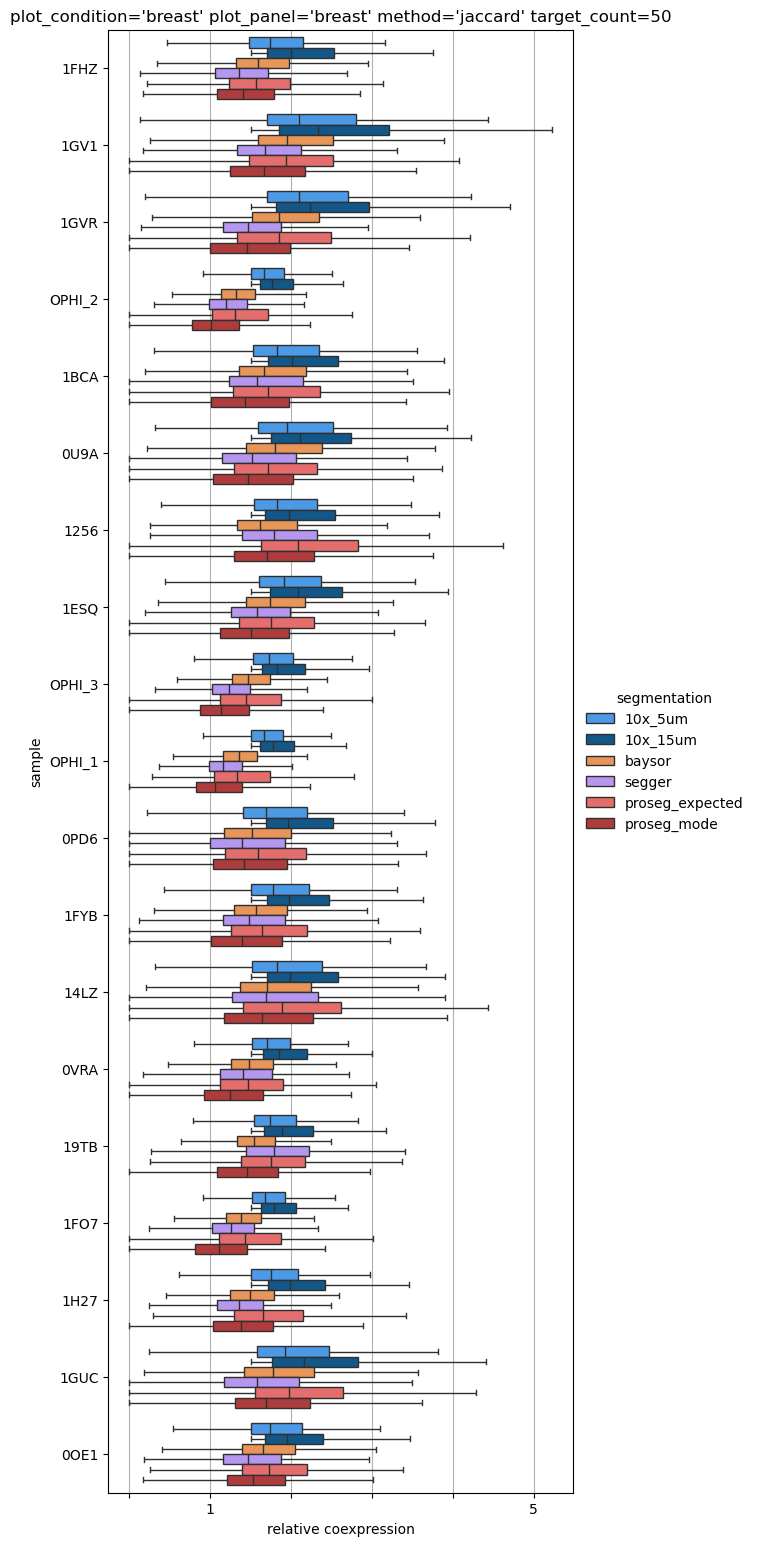

/tmp/ipykernel_2839363/2284901780.py:192: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([format_ticks(x) for x in ax.get_xticks()])


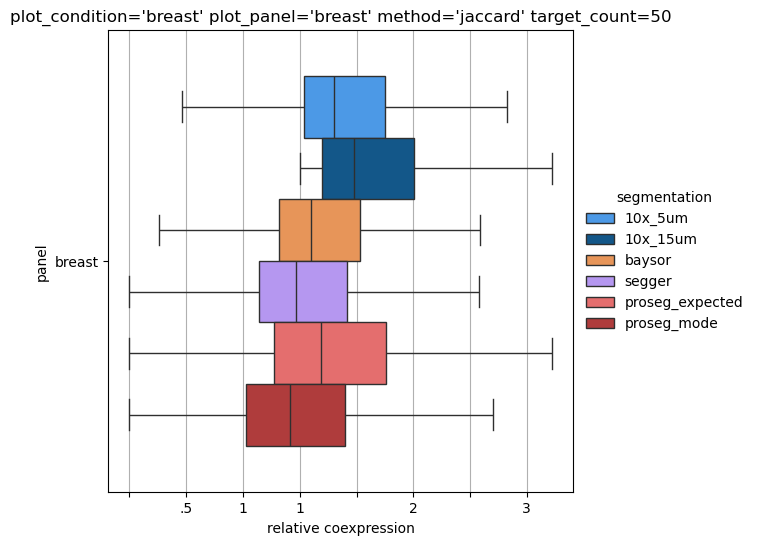

In [100]:
from pathlib import Path
import sys
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import natsort

sys.path.append("workflow/scripts/")
import readwrite
import coexpression



def float_or_str(value):
    if value == "auto":
        return value
    try:
        return float(value)
    except ValueError:
        raise argparse.ArgumentTypeError(f"Invalid value: {value}. Must be a float or 'auto'.")


# def format_ticks(x):
#     if x < 0.1:
#         return ""
#     elif x < 1:
#         return f".{str(x.round(6))[2:]}"
#     else:
#         return int(x)


def format_ticks(x):
    x_str = str(x.round(6))
    if "5" in x_str or "1" in x_str:
        if x < 1:
            return f".{x_str[2:]}"
        else:
            return int(x)
    else:
        return ""


results_dir = Path(cfg['results_dir'])
figures_dir = Path(cfg['figures_dir'])
palette_dir = Path(cfg['xenium_metadata_dir'])

# Params
segmentation_palette = palette_dir / 'col_palette_segmentation.csv'

# Access the arguments
panel = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/coexpression/10x_0um/breast/breast')
method = 'jaccard'
target_count = 50
min_positivity_rate = 0.01
min_cond_coex=0.
min_cond_coex_mode='both'
cc_cutoff = 1.5
log = False
ref_segmentation = '10x_0um'
ref_oversegmentation = '10x_15um'
palette = pd.read_csv(segmentation_palette, index_col=0).iloc[:, 0]
showfliers = False

# vars
coexpression_dir = panel.parents[2]
plot_panel = panel.stem
plot_condition = panel.parents[0].stem
xenium_levels = ["segmentation", "condition", "panel", "donor", "sample"]
hue = "segmentation"
hue_order = ['10x_mm_0um','10x_mm_5um','10x_mm_15um','10x_0um','10x_5um','10x_15um','baysor','proseg','segger']

# Read coexpression results
cc_paths = []
for segmentation in (segmentations := coexpression_dir.iterdir()):
    for condition in (conditions := segmentation.iterdir()):
        if condition.stem != plot_condition:
            continue
        for panel in (panels := condition.iterdir()):
            if panel.stem != plot_panel:
                continue
            for donor in (donors := panel.iterdir()):
                for sample in (samples := donor.iterdir()):
                    k = (
                        segmentation.stem,
                        condition.stem,
                        panel.stem,
                        donor.stem,
                        sample.stem,
                    )

                    cc_paths.append((k, method, target_count))

CC, pos_rate = readwrite.read_coexpression_files(cc_paths, coexpression_dir)


# automatically select min_cond_coex
if method in ["conditional", "jaccard"] and min_cond_coex == "auto":
    min_cond_coex = float(np.min([np.nanmin(CC[k][method, target_count].replace(0.0, np.nan)) for k in CC.keys()]))


# compute ratio with ref_segmentation
CCdiff = {}
spurious_gene_pairs = {}
for k in CC.keys():
    if k[0] == ref_segmentation:
        continue

    CCdiff[k] = {}
    spurious_gene_pairs[k] = {}

    k_ref = (ref_segmentation, *k[1:])

    (CCdiff[k][method, target_count], spurious_gene_pairs[k][method, target_count]) = (
        coexpression.compare_segmentations(
            CC_ref_seg=CC[k_ref][method, target_count],
            CC_other_seg=CC[k][method, target_count],
            pos_rate_ref_seg=pos_rate[k_ref][method, target_count],
            pos_rate_other_seg=pos_rate[k][method, target_count],
            min_positivity_rate=min_positivity_rate,
            min_cond_coex=min_cond_coex,
            min_cond_coex_mode=min_cond_coex_mode,
            cc_cutoff=cc_cutoff,
            method=method,
        )
    )


# extract spurious gene pairs based on ref_oversegmentation/ref_segmentation ratio
# and stack into one df
keys = pd.DataFrame(CCdiff.keys(), columns=xenium_levels)

data = []
for _, k in keys.iterrows():
    k_ref_over = (ref_oversegmentation, *k[1:])

    mat = CCdiff[*k][method, target_count]

    i = spurious_gene_pairs[k_ref_over][method, target_count][:, 0]
    j = spurious_gene_pairs[k_ref_over][method, target_count][:, 1]
    flat_values = mat.values[mat.index.get_indexer(i), mat.columns.get_indexer(j)]
    data.extend(np.hstack((np.tile(k, (len(i), 1)), i[:, None], j[:, None], flat_values[:, None])))


# Convert to DataFrame for plotting
df = pd.DataFrame(data, columns=xenium_levels + ["genei", "genej", "relative coexpression"])
df["relative coexpression"] = df["relative coexpression"].astype(float)


# plotting params, palette
unique_labels = [ct for ct in hue_order if ct in np.unique(df[hue].dropna())]
unique_labels = unique_labels + [ct for ct in np.unique(df[hue].dropna()) if ct not in unique_labels]
palette = {u: palette[u] for u in unique_labels}


# Create sample violinplot
for y in ["sample", "panel"]:
    if y == "sample":
        figsize = (6, df["sample"].nunique())
        # out_file_ = out_file_plot_sample
    else:
        figsize = (6, 6)
        # out_file_ = out_file_plot_panel

    plt.figure(figsize=figsize)
    ax = plt.subplot()
    g = sns.boxplot(
        data=df,
        x="relative coexpression",
        y=y,
        hue=hue,
        hue_order=unique_labels,
        palette=palette,
        # cut=0,
        # width=0.8,
        # inner="quart",
        showfliers=showfliers,
        flierprops={
            "marker": "o",
            "color": "black",
            "markersize": 1,
            "markerfacecolor": "w",
        },
    )

    # sns.despine(offset=10, trim=True)

    if not log:
        ax.set_xticklabels([format_ticks(x) for x in ax.get_xticks(minor=True)], minor=True)
        ax.set_xticklabels([format_ticks(x) for x in ax.get_xticks()])
        ax.tick_params(axis="both", which="minor", labelsize=6)

    ax.xaxis.grid(True)

    plt.title(f"{plot_condition=} {plot_panel=} {method=} {target_count=}")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title=hue, frameon=False)
    plt.gca().xaxis.grid(True)
    # plt.savefig(out_file_, dpi=dpi, bbox_inches="tight")
    plt.show()


In [ ]:
from pathlib import Path
import sys
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import natsort

sys.path.append("workflow/scripts/")
import readwrite
import coexpression


def float_or_str(value):
    if value == "auto":
        return value
    try:
        return float(value)
    except ValueError:
        raise argparse.ArgumentTypeError(f"Invalid value: {value}. Must be a float or 'auto'.")


def format_ticks(x):
    if x < 1 and '5' in str(x):
        return f".{str(x.round(6))[2:]}"
    else:
        return int(x)



# Access the arguments
coexpression_dir = results_dir / 'coexpression'
plot_condition = 'breast'
plot_panel = 'breast'
method = 'jaccard'
target_count = 50
min_positivity_rate = 0.01
min_cond_coex=0.
min_cond_coex_mode='both'
cc_cutoff = 1.5
ref_segmentation = '10x_0um'
ref_oversegmentation = '10x_15um'
palette = pd.read_csv(segmentation_palette, index_col=0).iloc[:, 0]
showfliers = False
log_scale = True


# vars
xenium_levels = ["segmentation", "condition", "panel", "donor", "sample"]
hue = "segmentation"
hue_order = ["10x_mm_0um", "10x_mm_5um", "10x_mm_15um", "10x_0um", "10x_5um", "10x_15um", "baysor", "proseg", "segger"]


# Read coexpression results
cc_paths = []
for segmentation in (segmentations := coexpression_dir.iterdir()):
    for condition in (conditions := segmentation.iterdir()):
        if condition.stem != plot_condition:
            continue
        for panel in (panels := condition.iterdir()):
            if panel.stem != plot_panel:
                continue
            for donor in (donors := panel.iterdir()):
                for sample in (samples := donor.iterdir()):
                    k = (
                        segmentation.stem,
                        condition.stem,
                        panel.stem,
                        donor.stem,
                        sample.stem,
                    )

                    cc_paths.append((k, method, target_count))

CC, pos_rate = readwrite.read_coexpression_files(cc_paths, coexpression_dir)


# automatically select min_cond_coex
if method in ["conditional", "jaccard"] and min_cond_coex == "auto":
    min_cond_coex = float(np.min([np.nanmin(CC[k][method, target_count].replace(0.0, np.nan)) for k in CC.keys()]))


# compute ratio with ref_segmentation
CCdiff = {}
spurious_gene_pairs = {}
for k in CC.keys():
    if k[0] == ref_segmentation:
        continue

    CCdiff[k] = {}
    spurious_gene_pairs[k] = {}

    k_ref = (ref_segmentation, *k[1:])

    (CCdiff[k][method, target_count], spurious_gene_pairs[k][method, target_count]) = (
        coexpression.compare_segmentations(
            CC_ref_seg=CC[k_ref][method, target_count],
            CC_other_seg=CC[k][method, target_count],
            pos_rate_ref_seg=pos_rate[k_ref][method, target_count],
            pos_rate_other_seg=pos_rate[k][method, target_count],
            min_positivity_rate=min_positivity_rate,
            min_cond_coex=min_cond_coex,
            min_cond_coex_mode=min_cond_coex_mode,
            cc_cutoff=cc_cutoff,
            method=method,
        )
    )


# extract spurious gene pairs based on ref_oversegmentation/ref_segmentation ratio
# and stack into one df
keys = pd.DataFrame(CCdiff.keys(), columns=xenium_levels)

data = []
for _, k in keys.iterrows():
    k_ref_over = (ref_oversegmentation, *k[1:])

    mat = CCdiff[*k][method, target_count]

    i = spurious_gene_pairs[k_ref_over][method, target_count][:, 0]
    j = spurious_gene_pairs[k_ref_over][method, target_count][:, 1]
    flat_values = mat.values[mat.index.get_indexer(i), mat.columns.get_indexer(j)]
    data.extend(np.hstack((np.tile(k, (len(i), 1)), i[:, None], j[:, None], flat_values[:, None])))


# Convert to DataFrame for plotting
df = pd.DataFrame(data, columns=xenium_levels + ["genei", "genej", "relative coexpression"])
df["relative coexpression"] = df["relative coexpression"].astype(float)


# plotting params, palette
unique_labels = [ct for ct in hue_order if ct in np.unique(df[hue].dropna())]
unique_labels = unique_labels + [ct for ct in np.unique(df[hue].dropna()) if ct not in unique_labels]
palette = {u: palette[u] for u in unique_labels}


# Create boxplot
for y in ["sample", "panel"]:
    if y == "sample":
        figsize = (6, df["sample"].nunique())
        # out_file_ = out_file_plot_sample
    else:
        figsize = (6, 6)
        # out_file_ = out_file_plot_panel

    plt.figure(figsize=figsize)
    ax = plt.subplot()
    g = sns.boxplot(
        data=df,
        x="relative coexpression",
        y=y,
        hue=hue,
        hue_order=unique_labels,
        palette=palette,
        # cut=0,
        # width=0.8,
        # inner="quart",
        log_scale=log_scale,
        showfliers=showfliers,
        flierprops={
            "marker": "o",
            "color": "black",
            "markersize": 1,
            "markerfacecolor": "w",
        },
    )

    # sns.despine(offset=10, trim=True)

    if log_scale:
        ax.set_xticklabels([format_ticks(x) for x in ax.get_xticks(minor=True)], minor=True)
        ax.set_xticklabels([format_ticks(x) for x in ax.get_xticks()])
        ax.tick_params(axis="both", which="minor", labelsize=8)

    ax.xaxis.grid(True)
    plt.title(f"{plot_condition=} {plot_panel=} {method=} {target_count=}")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title=hue, frameon=False)
    plt.savefig(out_file_, dpi=dpi, bbox_inches="tight")
    plt.close()

# df.to_parquet(out_file_gene_pairs)


## plotting script panel markers

In [46]:
cell_type_markers_path = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/markers/cellmarker_cell_types_markers.json'
# cell_type_markers_path = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/mesothelioma/data/markers/hubmap_cell_types_markers_DB.json'
column = 'canonical'
df_markers  = pd.read_json(cell_type_markers_path)
df_markers = df_markers[column].explode().reset_index().rename(columns={'index': 'cell_type', column: 'marker'})

if 'mesothelioma' in cell_type_markers_path:
    df_markers['cell_type'] = df_markers['cell_type'].rename({
        'type I pneumocyte':'pneumocyte',
        'type II pneumocyte':'pneumocyte',
        'fibroblast of lung':'fibroblast',
        'pulmonary artery endothelial cell':'endothelial cell',
        'endothelial cell of lymphatic vessel':'endothelial cell'})
        
df_markers.loc[len(df_markers)]= ['T cell','CD3E']
df_markers = df_markers[~(df_markers.duplicated('marker', keep=False))]
# df_markers = df_markers.groupby('cell_type')[df_markers.columns].apply(lambda x: x.sample(min(len(x), 30), random_state=0)).reset_index(drop=True)
df_markers.to_csv(cfg['markers_dir']+'non_overlapping_cell_type_markers.csv')

In [97]:
# chuvio_markers_path = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/markers/CHUV_IO_340_panel.csv'
breast_markers_path = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/markers/Xenium_hBreast_v1_metadata.csv'
lung_markers_path = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/markers/Xenium_hLung_v1_metadata.csv'
lung5k_markers_path = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/markers/XeniumPrimeHuman5Kpan_tissue_pathways_metadata.csv'

panel_path = lung_markers_path

df_markers = pd.read_csv(panel_path)
df_markers = df_markers.rename(columns={'Gene':'gene_name','Annotation':'cell_type','Gene ID':'gene_name','1st definition':'cell_type'})[['gene_name','cell_type']]
df_markers = df_markers[~df_markers['cell_type'].isna()]
df_markers['cell_type'] = df_markers['cell_type'].str.split(';')
df_markers = df_markers[['gene_name','cell_type']].explode('cell_type')
df_markers = df_markers[~(df_markers.duplicated('gene_name', keep=False))]
df_markers

,gene_name,cell_type
0,ACE,Capillary cell
1,ACE2,COVID-19
2,ACKR1,Vein cell
3,ADAM17,Classical monocyte
4,ADAM28,B cell
...,...,...
284,VSIG4,Macrophage
285,VWF,Endothelial cell
286,WFS1,Alveolar type 1 cell
287,WNT2,Fibroblast


In [ ]:
from pathlib import Path
import sys
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sys.path.append("workflow/scripts/")
import readwrite
import coexpression

results_dir = Path(cfg['results_dir'])
figures_dir = Path(cfg['figures_dir'])
palette_dir = Path(cfg['xenium_metadata_dir'])

# Params
segmentation_palette = palette_dir / 'col_palette_segmentation.csv'

# Access the arguments
panel = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/coexpression/10x_0um/breast/breast')
method = 'jaccard'
target_count = 50
min_positivity_rate = 0.01
cc_cutoff = -np.inf
log2 = True
ref_segmentation = '10x_0um'
ref_oversegmentation = '10x_15um'
palette = pd.read_csv(segmentation_palette, index_col=0).iloc[:, 0]
df_markers = pd.read_csv(cfg['markers_dir']+'non_overlapping_cell_type_markers.csv',index_col=0)

# vars
coexpression_dir = panel.parents[2]
plot_panel = panel.stem
plot_condition = panel.parents[0].stem
xenium_levels = ["segmentation", "condition", "panel", "donor", "sample"]
hue = "segmentation"
hue_order = ['10x_mm_0um','10x_mm_5um','10x_mm_15um','10x_0um','10x_5um','10x_15um','baysor','proseg','segger']

# Read coexpression results
cc_paths = []
for segmentation in (segmentations := coexpression_dir.iterdir()):
    for condition in (conditions := segmentation.iterdir()):
        if condition.stem != plot_condition:
            continue
        for panel in (panels := condition.iterdir()):
            if panel.stem != plot_panel:
                continue
            for donor in (donors := panel.iterdir()):
                for sample in (samples := donor.iterdir()):
                    k = (
                        segmentation.stem,
                        condition.stem,
                        panel.stem,
                        donor.stem,
                        sample.stem,
                    )

                    cc_paths.append((k, method, target_count))


CC, pos_rate = readwrite.read_coexpression_files(cc_paths, coexpression_dir)

if method in ["conditional", "jaccard"]:
    min_cond_coex = float(
        np.min(
            [
                np.nanmin(CC[k][method, target_count].replace(0.0, np.nan))
                for k in CC.keys()
            ]
        )
    )
else:
    min_cond_coex = 0.0

# compute ratio with ref_segmentation
CCdiff = {}
spurious_gene_pairs = {}
for k in CC.keys():
    if k[0] == ref_segmentation:
        continue

    CCdiff[k] = {}
    spurious_gene_pairs[k] = {}

    k_ref = (ref_segmentation, *k[1:])

    (CCdiff[k][method, target_count], spurious_gene_pairs[k][method, target_count]) = (
        coexpression.compare_segmentations(
            CC_ref_seg=CC[k_ref][method, target_count],
            CC_other_seg=CC[k][method, target_count],
            pos_rate_ref_seg=pos_rate[k_ref][method, target_count],
            pos_rate_other_seg=pos_rate[k][method, target_count],
            min_positivity_rate=min_positivity_rate,
            cc_cutoff=cc_cutoff,
            min_cond_coex=min_cond_coex,
            method=method,
            log2=False,
        )
    )



# extract exclusive gene pairs 
genes = CC[list(CC)[0]][method,target_count].columns
df_markers = df_markers[df_markers.iloc[:,1].isin(genes)]
exclusive_gene_pairs = coexpression.get_exclusive_gene_pairs(df_markers)
i = exclusive_gene_pairs.iloc[:,0].values
j = exclusive_gene_pairs.iloc[:,1].values

# extract spurious gene pairs based on ref_oversegmentation/ref_segmentation ratio
# and stack into one df
keys = pd.DataFrame(CCdiff.keys(), columns=xenium_levels)

data = []
for _, k in keys.iterrows():
    k_ref_over = (ref_oversegmentation, *k[1:])

    mat = CCdiff[*k][method, target_count]
    if log2:
        with warnings.catch_warnings(action="ignore"):
            mat = np.log2(mat)

    flat_values = mat.values[mat.index.get_indexer(i), mat.columns.get_indexer(j)]
    data.extend(
        np.hstack(
            (np.tile(k, (len(i), 1)), i[:, None], j[:, None], flat_values[:, None])
        )
    )


# Convert to DataFrame for plotting
df = pd.DataFrame(
    data, columns=xenium_levels + ["genei", "genej", "log2 relative coexpression"]
)
df["log2 relative coexpression"] = df["log2 relative coexpression"].astype(float)

# set inf values to max
# max = df["log2 relative coexpression"][df["log2 relative coexpression"]!=np.inf].max()
# df["log2 relative coexpression"] = df["log2 relative coexpression"].replace(np.inf, max)


# plotting params, palette
unique_labels = [ct for ct in hue_order if ct in np.unique(df[hue].dropna())]
unique_labels = unique_labels + [ct for ct in np.unique(df[hue].dropna()) if ct not in unique_labels]
palette = {u: palette[u] for u in unique_labels}

# Create sample violinplot
plt.figure(figsize=(6, df["sample"].nunique()))
g = sns.violinplot(
    data=df,
    x="log2 relative coexpression",
    y="sample",
    hue=hue,
    hue_order=unique_labels,
    palette=palette,
    cut=0,
    width=0.8,
    inner="quart",
)

plt.title(f"{plot_condition=} {plot_panel=} {method=} {target_count=}")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title=hue, frameon=False)
sns.despine(offset=10, trim=True)
plt.gca().xaxis.grid(True)
# plt.savefig(out_file_plot_sample, dpi=300, bbox_inches="tight")
plt.show()


# Create panel violinplot
plt.figure(figsize=(6, 6))
g = sns.violinplot(
    data=df,
    x="log2 relative coexpression",
    y="panel",
    hue=hue,
    hue_order=unique_labels,
    palette=palette,
    cut=0,
    width=0.8,
)

plt.title(f"{plot_condition=} {method=} {target_count=}")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title=hue, frameon=False)
sns.despine(offset=10, trim=True)
plt.gca().xaxis.grid(True)
# plt.savefig(out_file_plot_panel, dpi=300, bbox_inches="tight")
plt.show()

## plotting script condition

In [78]:
Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/breast/0OE1/0OE1/normalised_results/outs')

PosixPath('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation')

In [72]:
# common genes between panels
xenium_dir = Path(cfg['xenium_processed_data_dir'])
ref_segmentation = sorted(xenium_dir.iterdir())[0] # any segmentation will do

# load probe count info
panels_genes = {}
for condition in ref_segmentation.iterdir():
    for panel in condition.iterdir():
        # get any sample
        donor = list(panel.iterdir())[0]
        sample = list(donor.iterdir())[0]

        name = '/'.join((condition.stem,panel.stem,donor.stem,sample.stem))
        p = ref_segmentation / f'{name}/normalised_results/outs/gene_panel.json'
        panels_genes[condition.stem, panel.stem] = readwrite.get_gene_panel_info(p).query('id.notnull()')['name']
common_genes = list(set.intersection(*map(set, panels_genes.values())))

In [74]:
len(common_genes)

36

In [ ]:
from pathlib import Path
import sys
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import natsort

sys.path.append("workflow/scripts/")
import readwrite
import coexpression

def float_or_none(value):
    if value.lower() == "auto":
        return None
    try:
        return float(value)
    except ValueError:
        raise argparse.ArgumentTypeError(f"Invalid value: {value}. Must be a float or 'auto'.")

# parser.add_argument("--min_cond_coex", type=float_or_none, help="A float value or 'auto'.")

results_dir = Path(cfg['results_dir'])
figures_dir = Path(cfg['figures_dir'])
palette_dir = Path(cfg['xenium_metadata_dir'])

# Params
segmentation_palette = palette_dir / 'col_palette_segmentation.csv'

# Access the arguments
condition = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/coexpression/10x_0um/NSCLC/')
method = 'conditional'
target_count = 50
min_positivity_rate = 0.01
min_cond_coex_mode = 'ref'
cc_cutoff = 1.5
log2 = False
ref_segmentation = '10x_0um'
ref_oversegmentation = '10x_15um'
palette = pd.read_csv(segmentation_palette, index_col=0).iloc[:, 0]
n_top_gene_pairs = 5000000000

# vars
coexpression_dir = condition.parents[1]
plot_condition = condition.stem
xenium_levels = ["segmentation", "condition", "panel", "donor", "sample"]
hue = "segmentation"
hue_order = ['10x_mm_0um','10x_mm_5um','10x_mm_15um','10x_0um','10x_5um','10x_15um','baysor','proseg','segger']

# Read coexpression results
cc_paths = []
for segmentation in (segmentations := coexpression_dir.iterdir()):
    for condition in (conditions := segmentation.iterdir()):
        for panel in (panels := condition.iterdir()):
            for donor in (donors := panel.iterdir()):
                for sample in (samples := donor.iterdir()):
                    k = (
                        segmentation.stem,
                        condition.stem,
                        panel.stem,
                        donor.stem,
                        sample.stem,
                    )

                    cc_paths.append((k, method, target_count))


CC, pos_rate = readwrite.read_coexpression_files(cc_paths, coexpression_dir)

# automatically select min_cond_coex
if method in ["conditional", "jaccard"] and min_cond_coex == 'auto':
    min_cond_coex = float(
        np.min(
            [
                np.nanmin(CC[k][method, target_count].replace(0.0, np.nan))
                for k in CC.keys()
            ]
        )
    )

# compute ratios with ref_segmentation
CCdiff = {}
spurious_gene_pairs = {}
for k in CC.keys():
    if k[0] == ref_segmentation:
        continue

    CCdiff[k] = {}
    spurious_gene_pairs[k] = {}

    k_ref = (ref_segmentation, *k[1:])

    (CCdiff[k][method, target_count], spurious_gene_pairs[k][method, target_count]) = (
        coexpression.compare_segmentations(
            CC_ref_seg=CC[k_ref][method, target_count],
            CC_other_seg=CC[k][method, target_count],
            pos_rate_ref_seg=pos_rate[k_ref][method, target_count],
            pos_rate_other_seg=pos_rate[k][method, target_count],
            min_positivity_rate=min_positivity_rate,
            min_cond_coex=min_cond_coex,
            min_cond_coex_mode=min_cond_coex_mode,
            cc_cutoff=cc_cutoff,
            method=method,
            log2=False,
        )
    )


# genes in each panel
panels_genes = [ CCdiff[k][method, target_count].columns for k in CCdiff.keys() if k[0]==ref_oversegmentation ]

# spurious genes in each panel for ref_oversegmentation
panels_spurious_gene_pairs =  pd.concat(
    [ pd.DataFrame(spurious_gene_pairs[k][method,target_count]) 
      for k in CCdiff.keys() if k[0] == ref_oversegmentation ]
).drop_duplicates()

# common genes between panels
common_genes = list(set.intersection(*map(set, panels_genes)))

# common spurious genes across panels
common_spurious_gene_pairs = panels_spurious_gene_pairs[panels_spurious_gene_pairs.isin(common_genes).all(1)].values
i = common_spurious_gene_pairs[:,0]
j = common_spurious_gene_pairs[:,1]

# reduce to top 50
if n_top_gene_pairs < len(i):
    top_values = []
    for k in CCdiff.keys():
        if k[0]==ref_oversegmentation:
            mat = CCdiff[k][method, target_count]

            top_values.append(mat.values[mat.index.get_indexer(i), mat.columns.get_indexer(j)])

    top_values = np.nanmean(top_values,axis=0)
    top_values_idx = np.argsort(top_values)[::-1][:n_top_gene_pairs]

    i = i[top_values_idx]
    j = j[top_values_idx]
else:
    n_top_gene_pairs = len(i)


# extract spurious gene pairs based on ref_oversegmentation/ref_segmentation ratio
# and stack into one df
keys = pd.DataFrame(CCdiff.keys(), columns=xenium_levels)

data = []
for _, k in keys.iterrows():
    k_ref_over = (ref_oversegmentation, *k[1:])

    mat = CCdiff[*k][method, target_count]
    
    if log2:
        with warnings.catch_warnings(action="ignore"):
            mat = np.log2(mat)

    flat_values = mat.values[mat.index.get_indexer(i), mat.columns.get_indexer(j)]
    data.extend(np.hstack((np.tile(k, (len(i), 1)), i[:, None], j[:,None], flat_values[:, None])))


# Convert to DataFrame for plotting
relative_coexpression_colname = "log2 relative coexpression" if log2 else "relative coexpression" 
df = pd.DataFrame(data, columns=xenium_levels + ["genei", "genej", relative_coexpression_colname])
df[relative_coexpression_colname] = df[relative_coexpression_colname].astype(float)

if not log2:
    df = df[df[relative_coexpression_colname]>0].replace([np.inf, -np.inf], np.nan).dropna()

# plotting params, palette
unique_labels = [ct for ct in hue_order if ct in np.unique(df[hue].dropna())]
unique_labels = unique_labels + [ct for ct in np.unique(df[hue].dropna()) if ct not in unique_labels]
palette = {u: palette[u] for u in unique_labels}

# Create joint boxplot
plt.figure(figsize=(6, df["panel"].nunique()*1.5))
ax = plt.subplot()
g = sns.boxplot(
    data=df,
    x=relative_coexpression_colname,
    y="panel",
    hue=hue,
    hue_order=unique_labels,
    palette=palette,
    # cut=0,
    width=0.8,
    # inner="quart",
    showfliers=True,
    flierprops={'marker': 'o', 'color': 'black', 'markersize': 1, 'markerfacecolor':'w',}  ,
    log_scale = not log2,
    ax=ax
)

sns.despine(offset=10, trim=True)

if not log2:
    def format_(x):
        if x < .1:
            return ""
        elif x < 1:
            return f".{str(x.round(6))[2:]}" 
        else:
            return int(x) 
    ax.set_xticklabels([format_(x) for x in ax.get_xticks(minor=True) ],minor=True)
    ax.set_xticklabels([format_(x) for x in ax.get_xticks() ])
    ax.tick_params(axis='both', which='minor', labelsize=6)

plt.title(f"{plot_condition=} {method=} {target_count=} {n_top_gene_pairs=}")
# plt.axvline(0, c="k", linestyle="-", zorder=-1, alpha=0.5)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title=hue, frameon=False)
ax.xaxis.grid(True)
plt.show()

In [ ]:
# Create joint boxplot
plt.figure(figsize=(6, df["panel"].nunique()*1.5))
ax = plt.subplot()
g = sns.boxplot(
    data=df,
    x=relative_coexpression_colname,
    y="panel",
    hue=hue,
    hue_order=unique_labels,
    palette=palette,
    # cut=0,
    width=0.8,
    # inner="quart",
    showfliers=False,
    flierprops={'marker': 'o', 'color': 'black', 'markersize': 1, 'markerfacecolor':'w',}  ,
    log_scale = not log2,
    ax=ax
)

sns.despine(offset=10, trim=True)

if not log2:
    def format_(x):
        if x < .1:
            return ""
        elif x < 1:
            return f".{str(x.round(6))[2:]}" 
        else:
            return int(x) 
    ax.set_xticklabels([format_(x) for x in ax.get_xticks(minor=True) ],minor=True)
    ax.set_xticklabels([format_(x) for x in ax.get_xticks() ])
    ax.tick_params(axis='both', which='minor', labelsize=6)

plt.title(f"{plot_condition=} {method=} {target_count=} {n_top_gene_pairs=}")
# plt.axvline(0, c="k", linestyle="-", zorder=-1, alpha=0.5)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title=hue, frameon=False)
ax.xaxis.grid(True)
plt.show()

## Coexpression genes

In [ ]:
segmentation = '10x_0um'
condition = 'NSCLC'
panel = 'lung'
method = 'conditional'
target_count = 50
df = pd.read_parquet(Path(cfg['results_dir'])/f'coexpression_gene_pairs/{segmentation}/{condition}/{panel}/coexpression_gene_pairs_{method}_{target_count=}.parquet')

df = df.dropna()
df['is_marker'] = df['genei'].isin(df_markers['marker']) & df['genej'].isin(df_markers['marker'])
sns.violinplot(df,x='log2 relative coexpression',y='segmentation',hue='is_marker')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title='is_marker', frameon=False)
sns.despine(offset=10, trim=True)
plt.gca().xaxis.grid(True)

In [ ]:
pd.set_option('display.max_rows', 500)

df_=df[np.inf!=df['log2 relative coexpression']].sort_values('log2 relative coexpression',ascending=False)[['genei','genej','log2 relative coexpression']][:100]
print(df_.to_string(index=False))

## Find coexpressed and spurious genes scRNA

In [ ]:
ad = sc.read(cfg['scrnaseq_processed_flex_full_zurich_h5ad'])
ad_panel = ad[:,[g for g in sd1.var_names if g in ad.var_names]]

# compute CC
CCnuc_found = CCnuc.loc[ad_panel.var_names,ad_panel.var_names]
CCnuc_sc, Xnuc_downdonord_sc, pos_nuc_sc, pos_rate_nuc_sc, mask_nuc_sc = coexpression.coexpression(ad_panel,return_all=1)
CCdiff_sc, spurious_gene_pairs_sc = coexpression.compare_segmentations(pos_rate_nuc_sc, pos_rate_nuc, CCnuc_sc, CCnuc_found, min_positivity_rate=0.01,cc_cutoff = 2)
spurious_genes_idx_sc = np.unique(np.where(spurious_gene_pairs_sc))
spurious_genes_sc = ad_panel.var_names[spurious_genes_idx_sc]
spurious_genes_markers_sc = df_markers_panel.loc[df_markers_panel['canonical'].isin(spurious_genes_sc),'canonical'].unique()

print(len(spurious_genes_markers_sc), 'marker genes /', len(spurious_genes_sc),'spurious panel genes found')

# plot
sns.set(font_scale=.8)
# sns.clustermap(CCnuc.loc[spurious_genes,spurious_genes],yticklabels=True,xticklabels=True,figsize=(10,10))
sns.clustermap(CCdiff_sc.loc[spurious_genes_markers_sc,spurious_genes_markers_sc],
    yticklabels=True,xticklabels=True,figsize=(15,15),vmin=None,vmax=4,cmap='RdBu_r',center=1)
plt.show()

df_ct_markers_cc_nuc_sc, df_cc_melt_nuc_sc = coexpression.coexpression_by_cell_type(CCnuc_sc,spurious_genes_markers_sc,df_markers_panel)
sns.heatmap(df_ct_markers_cc,cmap='Purples')
plt.show()

df_ct_markers_cc_diff_sc, df_cc_melt_diff_sc = coexpression.coexpression_by_cell_type(CCdiff_sc,spurious_genes_markers_sc,df_markers_panel)
sns.heatmap(df_ct_markers_cc,cmap='RdBu_r',center=1)
plt.show()

In [ ]:
## 
df_markers_panel_ct = df_markers_panel.set_index("canonical")
df_cc_melt = df_cc_melt_nuc_sc.copy()
df_cc_melt['ct_genei'] = ''
df_cc_melt['ct_genej'] = ''
for i, row in df_cc_melt.iterrows():
    ct_genei = df_markers_panel_ct.loc[row["genei"], "index"]
    ct_genej = df_markers_panel_ct.loc[row["genej"], "index"]

    if isinstance(ct_genei, str):
        ct_genei = [ct_genei]
    if isinstance(ct_genej, str):
        ct_genej = [ct_genej]
    df_cc_melt.loc[df_cc_melt["genei"] == row["genei"],'ct_genei'] = ' & '.join(ct_genei) 
    df_cc_melt.loc[df_cc_melt["genej"] == row["genej"],'ct_genej'] = ' & '.join(ct_genej)

display(df_cc_melt[:20])

## Coexpression based on computational marker genes

### Estimate genes coexpression from scRNA

In [ ]:
# load doublets
# result = pyreadr.read_r('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/dbuszta/meso/processed_data/new_data/doublets_by_donor.rds')[None]

# load data
ad_sc = sc.read_h5ad(cfg['scrnaseq_processed_flex_full_zurich_h5ad'])
# ad_sc.obs['doublet_status'] = result.iloc[:,0]
# ad_sc = ad_sc[ad_sc.obs['doublet_status']=='singlet']
# ad_sc.obs = ad_sc.obs.join(pd.read_csv(cfg['results_dir']+'annotation/cell_type_annotation.csv',index_col=0))

# filter to xenium genes
xenium_panel_genes = pd.read_csv(cfg['data_dir']+'xenium_chuvio_panel_genes.csv',index_col=0)['0']
ad_sc_panel = ad_sc[:,ad_sc.var_names.isin(xenium_panel_genes)]

CT_KEY = 'cell_type_harmonized_level2_consensus'
u_cell_types = ad_sc_panel.obs[CT_KEY].unique()

# get df with max fraction for each cell type
(df_fraction,df_difference, 
df_max_difference) = coexpression.find_markers(ad_sc_panel, CT_KEY, threshold_fraction = 1., threshold_diff = 0.)
df_difference_sorted = df_difference[df_difference.max().sort_values().index]

# get df with thresholded max fraction for each cell type
(_,df_difference_thresholded, 
 df_max_difference_thresholded) = coexpression.find_markers(ad_sc_panel, CT_KEY, threshold_fraction = 0.01, threshold_diff = 0.25)
df_difference_thresholded_sorted = df_difference_thresholded[df_difference_thresholded.max().sort_values().index]

for df_difference_sorted_, df_max_difference_ in zip([df_difference_sorted,df_difference_thresholded_sorted],
                                                     [df_max_difference,df_max_difference_thresholded]):

    ### Boxplots
    plt.figure(figsize=(8,30))

    flierprops = dict(marker='o', markersize=1, linestyle='none', markerfacecolor='black')
    ax = sns.boxplot(data=df_difference_sorted_, orient='h', flierprops=flierprops)

    # Loop over columns to find and highlight max fliers
    for i, col in enumerate(df_difference_sorted_.columns):
        data = df_difference_sorted_[col]
        max_val = data.max()  # Find maximum value in the column
        ax.scatter(max_val,i, color='red', edgecolor='black', zorder=5, s=20)

    plt.title("Difference in % of cells expressing")
    plt.show()

    ### Heatmap
    sns.heatmap(df_max_difference_)

# Define markers
df_markers_scores = pd.DataFrame(index=ad_sc_panel.var_names,columns=u_cell_types)

for cti in u_cell_types:
    cti_columns = df_difference_thresholded.columns.str.split("_").str[0] == cti

    df_markers_scores[cti] = df_difference_thresholded.loc[:,cti_columns].mean(1)

ct_markers = {}
for ct in u_cell_types:
    ct_scores = df_markers_scores[ct].sort_values(ascending=False).dropna()
    markers_ = list(ct_scores[(ct_scores>0.)][:10].index)

    if len(markers_) > 0:
        ct_markers[ct] = markers_

df_markers_computational = pd.DataFrame([
    {"index": k, "canonical": v}
    for k, values in ct_markers.items()
    for v in values
])

### Coexpression

In [ ]:
rctd_weights_key = 'weights_FLEX_original'

normalized_entropy_computational = {}
CC_computational = {}
CC_cells_sum_normalized_computational = {}

for segmentation in SEGMENTATIONS:

    normalized_entropy_computational[segmentation] = {}
    CC_computational[segmentation] = {}
    CC_cells_sum_normalized_computational[segmentation] = {}
        
    for k,ad_ in ads[segmentation].items():
        print(k)

        ad = ad_[ad_.uns[rctd_weights_key].index]

        ### Entropy
        W = ad.uns[rctd_weights_key].copy()
        W[W<0] = 0.
        W = sklearn.preprocessing.normalize(W,axis=0,norm='l1')
        normalized_entropy_computational[segmentation][k] = scipy.stats.entropy(W,axis=1)/np.log(W.shape[1])

        ### Coexpression
        # compute CC
        CC, X_downdonord, pos, pos_rate, mask = coexpression.coexpression(ad,target_count=30,method='jaccard')
        CC_computational[segmentation][k] = CC

        # load markers
        # df_markers_computational_panel = df_markers_computational[df_markers_computational['canonical'].isin(ad.var_names)]
        # u_markers_panel = df_markers_computational_panel['canonical'].unique()
        # marker_genes_idx = ad.var_names.isin(u_markers_panel)
        # print(len(u_markers_panel), 'marker genes /', ad.shape[1],'panel genes found')

        # df_ct_markers_cc = coexpression.coexpression_by_cell_type(CC,u_markers_panel,df_markers_computational_panel)
#         CC_cells = coexpression.coexpression_cells(pos)
#         CC_cells_sum = coexpression.coexpression_cells_score(CC_cells, marker_genes_idx)
#         CC_cells_sum_normalized_computational[k] = np.array(CC_cells_sum)/(marker_genes_idx.sum()**2)
#         break

# palette = {'singlet':'green','doublet_certain':'blue','doublet_uncertain':'orange','reject':'red'}
# for segmentation in SEGMENTATIONS[:1]:
#     for k,ad_ in ads[segmentation].items():
#         ad = ad_[ad_.uns[rctd_weights_key].index]

#         g = sns.jointplot(x=normalized_entropy_computational[k], y=CC_cells_sum_normalized_computational[k], palette=palette,hue=ad.obs['spot_class_FLEX_original'],kind="scatter", height=5,s=8,alpha=.3)
#         g.set_axis_labels(f'{k} - normalized RCTD weights normalized entropy', f'{k} - normalized coexpression score')
#         plt.show()
#         break

In [ ]:
rctd_weights_key = 'weights_FLEX_original'

# Define a function for processing one (segmentation, k) pair
def process_task(segmentation, k, ad_, rctd_weights_key):
    print(f"Processing {segmentation}, {k}")

    # Filter data
    ad = ad_[ad_.uns[rctd_weights_key].index]

    # Entropy computation
    W = ad.uns[rctd_weights_key].copy()
    W[W < 0] = 0.0
    W = sklearn.preprocessing.normalize(W, axis=0, norm='l1')
    normalized_entropy = scipy.stats.entropy(W, axis=1) / np.log(W.shape[1])

    # Coexpression computation
    CC, X_downdonord, pos, pos_rate, mask = coexpression.coexpression(ad, target_count=30, method='jaccard')

    return segmentation, k, normalized_entropy, CC

# Prepare the tasks
tasks = []
for segmentation in SEGMENTATIONS:
    for k, ad_ in ads[segmentation].items():
        tasks.append((segmentation, k, ad_, rctd_weights_key))

# Run tasks in parallel
results = Parallel(n_jobs=-1, backend="loky")(
    delayed(process_task)(segmentation, k, ad_, rctd_weights_key) for segmentation, k, ad_, rctd_weights_key in tasks
)

# Collect results
normalized_entropy_computational = {seg: {} for seg in SEGMENTATIONS}
CC_computational = {seg: {} for seg in SEGMENTATIONS}

for segmentation, k, entropy, CC in results:
    normalized_entropy_computational[segmentation][k] = entropy
    CC_computational[segmentation][k] = CC


In [ ]:
donor = '16MD_run14'
coexpr_scores = pd.DataFrame()
normalized_entropy_computational_scores = pd.DataFrame()
for segmentation,CC_segmentations in CC_computational.items():
    for donor, CC_donor in CC_segmentations.items():
        coexpr_scores.loc[segmentation,donor] = CC_donor.values[np.triu_indices_from(CC_donor,1)].sum()
        normalized_entropy_computational_scores.loc[segmentation,donor] = normalized_entropy_computational[segmentation][donor].sum()

sns.clustermap(coexpr_scores.fillna(coexpr_scores.mean()),figsize=(10,5),cmap='Reds')

coexpr_scores_norm = coexpr_scores.fillna(coexpr_scores.mean())
sns.clustermap(coexpr_scores_norm/coexpr_scores_norm.max(),figsize=(10,5),cmap='Reds')

sns.clustermap(normalized_entropy_computational_scores,figsize=(10,5),cmap='Reds')
sns.clustermap(normalized_entropy_computational_scores/normalized_entropy_computational_scores.max(),figsize=(10,5),cmap='Reds')

In [ ]:
median_transcripts_per_cell = pd.DataFrame()
for segmentation, ads_seg in ads.items():
    for donor, ad in ads_seg.items():
        median_transcripts_per_cell.loc[segmentation,donor] = ad.uns['metrics_summary'].loc[0,'median_transcripts_per_cell']

In [ ]:
df1 = normalized_entropy_computational_scores
df2 = coexpr_scores

plot_data = []
for idx in df1.index:
    for col in df1.columns:
        plot_data.append({
            'segmentation': idx,
            'donors': col,
            'normalized_entropy_computational_scores': df1.loc[idx, col],
            'coexpr_scores': df2.loc[idx, col]
        })

plot_df = pd.DataFrame(plot_data)

sns.boxplot(plot_df,x='segmentation',y='coexpr_scores');plt.show()
sns.boxplot(plot_df,x='segmentation',y='normalized_entropy_computational_scores')

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=plot_df,
    x='normalized_entropy_computational_scores',  # x-axis: values from df1
    y='coexpr_scores',  # y-axis: values from df2
    hue='segmentation',  # color based on segmentation
    style='donors',  # marker type based on donors
    s=50  # marker size
)

# plt.title('Scatter Plot: df1 vs df2')
# plt.xlabel('Values from df1')
# plt.ylabel('Values from df2')
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [ ]:
# Find universal markers
ad_sc_panel.var['n_cells'] = (ad_sc_panel.X>0).sum(0).A1
ad_sc_panel.var['n_cells'].hist(bins=100)
CC, X_downdonord, pos_, pos_rate_, mask_ = coexpression.coexpression(ad_sc_panel,target_count=None,min_cond_coex=0.)

threshold = 0.01
pos_rate_threshold = 0.01

valid_genes = np.where(pos_rate > pos_rate_threshold)[0]

gene_pairs_idx = np.vstack((CC.values<threshold).nonzero()).T
gene_pairs_idx_u = pd.DataFrame(gene_pairs_idx)
gene_pairs_idx_u['Key'] = gene_pairs_idx_u.apply(lambda row: tuple(sorted(row)), axis=1)
gene_pairs_idx_u = gene_pairs_idx_u.drop_duplicates(subset='Key').drop(columns='Key')
gene_pairs_idx_u = gene_pairs_idx_u[gene_pairs_idx_u.isin(valid_genes).sum(1)==2]
gene_pairs_idx_u = gene_pairs_idx_u.values
print(len(gene_pairs_idx_u))

# Score xenium donors per gene
# CC_computational_scores = {}
# for segmentation in SEGMENTATIONS:
#     for k,ad_ in ads[segmentation].items():
#         CC_computational_scores[segmentation][k] = CC_computational[segmentation][k].values[gene_pairs_idx_u[:,0],gene_pairs_idx_u[:,1]].sum(1)

# Score xenium donors per cell
# CC_cells_score = coexpression.coexpression_cells_score_gene_pairs(CC_cells, gene_pairs_idx_u)

# ad.obs['CC_cells_score'] = CC_cells_score
# ad.obs['CC_cells_score'].hist(bins=100)

# sc.set_figure_params(figsize=(10,10))
# sc.pl.spatial(ad,color='CC_cells_score',spot_size=10,)
# (ad.obs['CC_cells_score']>0).sum()

In [ ]:
sample_dir = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/breast/1FHZ/1FHZ')

matching = pd.read_parquet('/work/PRTNR/CHUV/DIR/rgottar1/spatial/data/xenium_paper/xenium/processed/segmentation/proseg/breast/breast/1FHZ/1FHZ/mapped_cell_ids/mapped_cell_ids.parquet')
proseg_results_dir = sample_dir / 'raw_results'
xeniumranger_dir = sample_dir / 'normalised_results/outs'

adata_expected = readwrite.read_xenium_sample(
    proseg_results_dir,
    cells_as_circles=False,
    cells_boundaries=False,
    cells_boundaries_layers=False,
    nucleus_boundaries=False,
    cells_labels=False,
    nucleus_labels=False,
    transcripts=False,
    morphology_mip=False,
    morphology_focus=False,
    aligned_images=False,
    anndata=True,
)
adata_expected.obs_names=adata_expected.obs_names.astype(str)

adata = readwrite.read_xenium_sample(
    xeniumranger_dir,
    cells_as_circles=False,
    cells_boundaries=False,
    cells_boundaries_layers=False,
    nucleus_boundaries=False,
    cells_labels=False,
    nucleus_labels=False,
    transcripts=False,
    morphology_mip=False,
    morphology_focus=False,
    aligned_images=False,
    anndata=True,
)


x=adata['ekkidcmm-1'].X.todense().A1
y=adata_expected[12641,adata.var_names].X.todense().A1
plt.scatter(x,y)
idx_zeros = x==0
(y[idx_zeros]>0).sum()

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


metrics_summary.csv not found at: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/breast/1FHZ/1FHZ/raw_results/metrics_summary.csv
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/br
         east/1FHZ/1FHZ/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
